In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
data = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [3]:
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [4]:
target = 'HeartDisease'

# Data Preprocessing

In [5]:
for col in data.columns:
  print(f'unique({col}) = {len(data[col].unique())}')

unique(Age) = 50
unique(Sex) = 2
unique(ChestPainType) = 4
unique(RestingBP) = 67
unique(Cholesterol) = 222
unique(FastingBS) = 2
unique(RestingECG) = 3
unique(MaxHR) = 119
unique(ExerciseAngina) = 2
unique(Oldpeak) = 53
unique(ST_Slope) = 3
unique(HeartDisease) = 2


In [6]:
def visualiseHistograms(data: pd.DataFrame, visualizableFields = []):
  n = len(visualizableFields)
  n = n // 2 + (n % 2 != 0)

  plt.figure(figsize = (10, 12))

  for idx, value in enumerate(visualizableFields):
    plt.subplot(n, 2, idx+1)
    data[value].hist()
    plt.title(f"{value} Distribution")
    plt.tight_layout(pad=2)

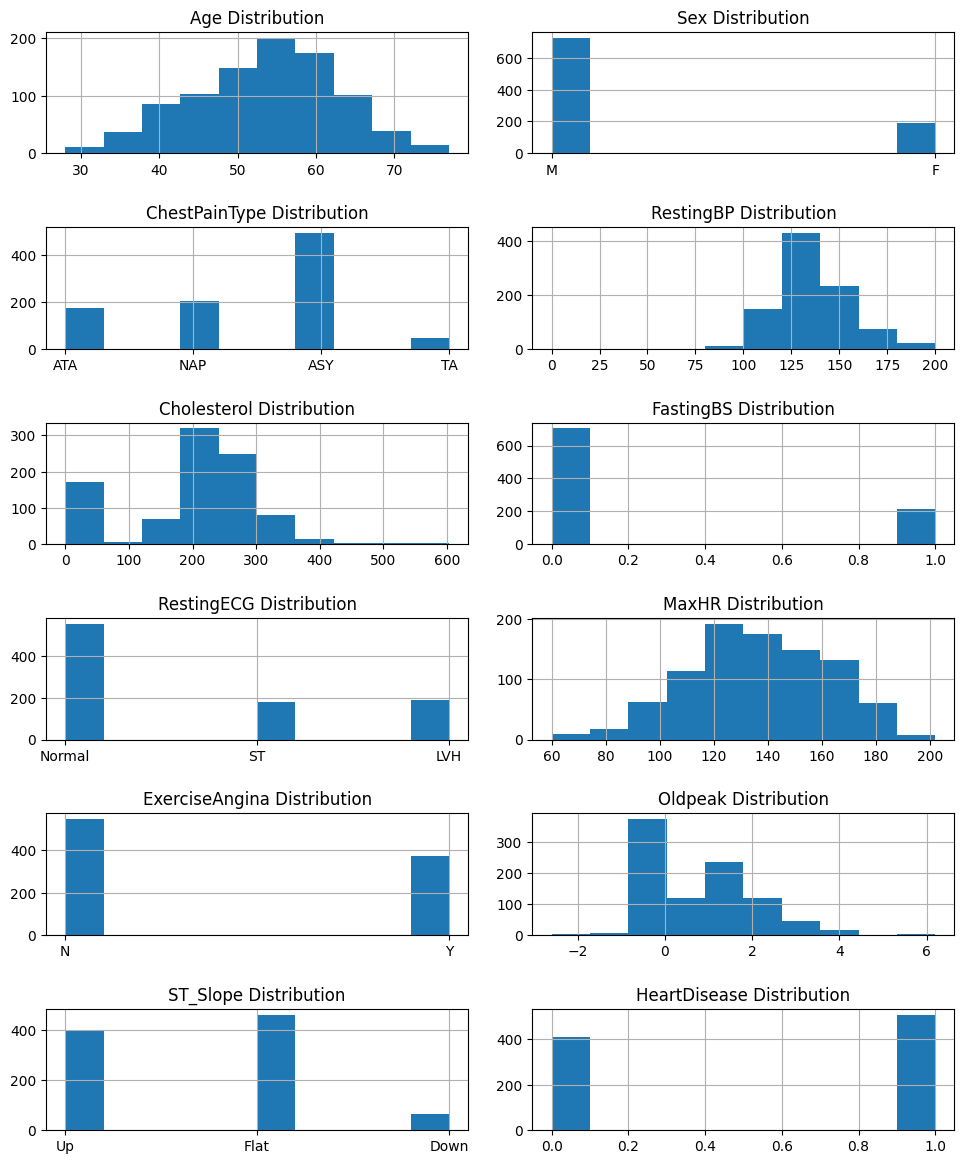

In [7]:
visualiseHistograms(data,data.columns)

In [8]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [9]:
def visualizeData(data: pd.DataFrame, visualizableFields = []):
    n = len(visualizableFields)
    n = n //2 +(n % 2 != 0)
    
    plt.figure(figsize = (10,12))
    
    for idx, value in enumerate(visualizableFields):
        plt.subplot(n,2,idx+1)
        sns.countplot(x=value, hue=target, data=data, palette="Set2")
        plt.title(f"{value} Distribution")
        plt.tight_layout()

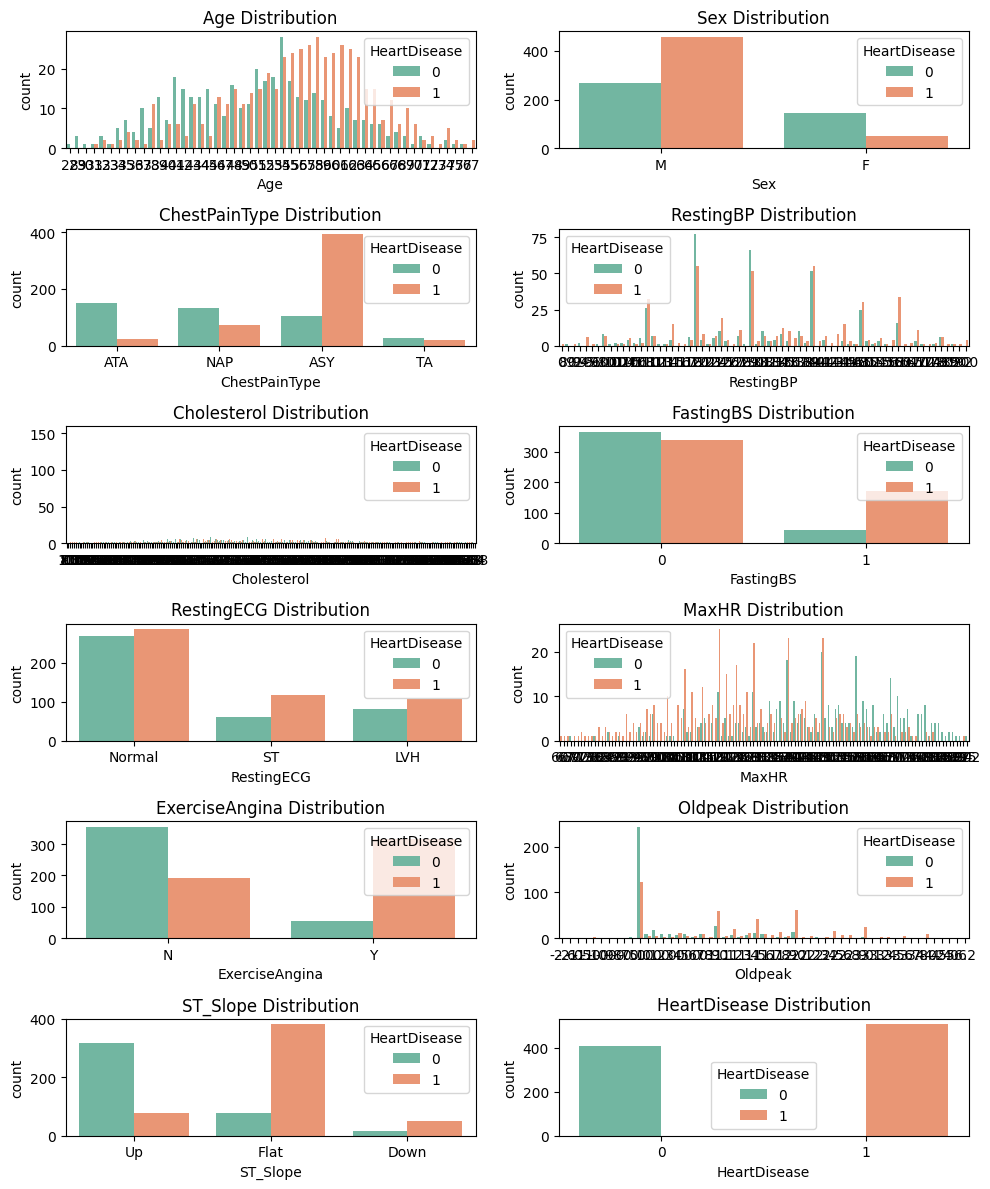

In [10]:
visualizeData(data, visualizableFields = data.columns)

In [11]:
def preprocessData(data: pd.DataFrame):
    data.drop(columns=[],inplace=True)
    return data

In [12]:
def encodingCategorialData(data: pd.DataFrame, isPred:bool=False):
    # Label encoding categprical fields
    cols2labelEncode = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    
    le = LabelEncoder()
    
    for col in cols2labelEncode:
        data[col]=le.fit_transform(data[col])
        
    return data

In [13]:
def zscoringData(data: pd.DataFrame):
    # Zscoring all the fields
    cols2zscore = data.keys()
    cols2zscore = cols2zscore.drop(target)
    data[cols2zscore] = data[cols2zscore].astype(float).apply(stats.zscore)
    
    return data

In [14]:
def getFeaturesAndLabels(data: pd.DataFrame):
    fields = data.keys().drop(target)
    
    features =data[fields].values.astype(float)
    labels = data[target].values.astype(int)
    
    #conversion to tensors
    featuresT = torch.Tensor(features)
    labelsT = torch.Tensor(labels)[:, None]
    
    return featuresT,labelsT

In [15]:
data = preprocessData(data)
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


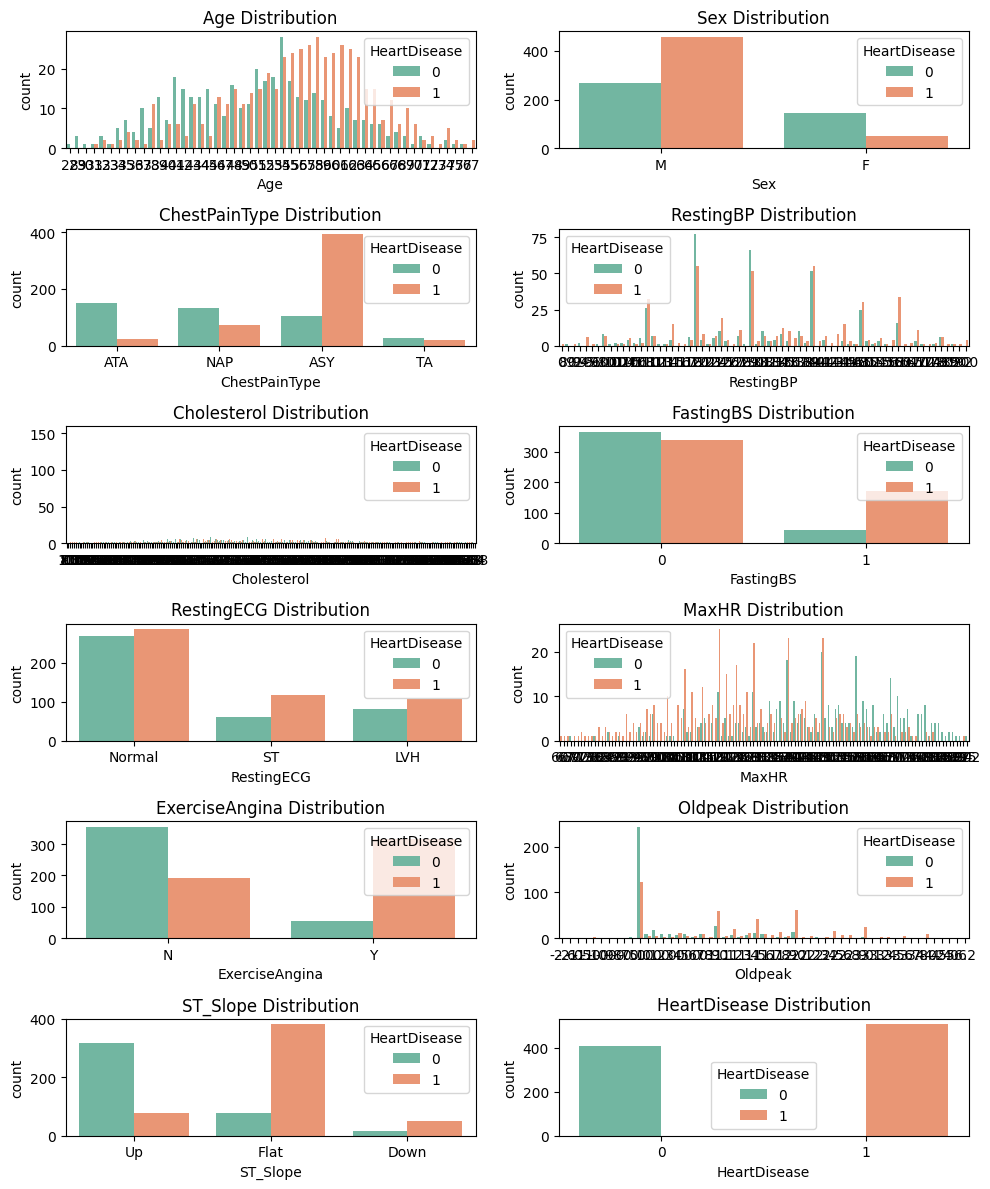

In [16]:
visualizeData(data, visualizableFields = data.columns)

In [17]:
data = encodingCategorialData(data)
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [18]:
data = zscoringData(data)
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,0.515952,0.229032,0.410909,0.825070,-0.551341,0.017255,1.382928,-0.823556,-0.832432,1.052114,0
1,-0.478484,-1.938163,1.275059,1.491752,-0.171961,-0.551341,0.017255,0.754157,-0.823556,0.105664,-0.596078,1
2,-1.751359,0.515952,0.229032,-0.129513,0.770188,-0.551341,1.601219,-1.525138,-0.823556,-0.832432,1.052114,0
3,-0.584556,-1.938163,-0.816995,0.302825,0.139040,-0.551341,0.017255,-1.132156,1.214246,0.574711,-0.596078,1
4,0.051881,0.515952,1.275059,0.951331,-0.034755,-0.551341,0.017255,-0.581981,-0.823556,-0.832432,1.052114,0


# Correlation Visualization

<Axes: >

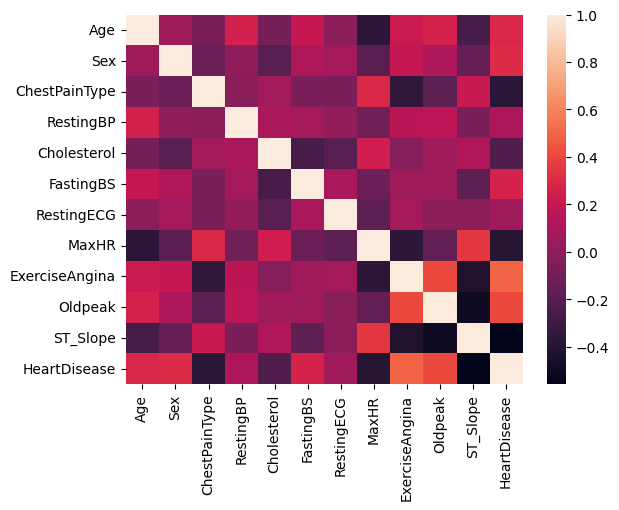

In [19]:
sns.heatmap(data.corr())

In [20]:
featuresT, labelsT = getFeaturesAndLabels(data)
train_data, test_data, train_labels, test_labels = train_test_split(featuresT, labelsT,
                                                                    shuffle=True, test_size=0.2)
print(f'Train data: {len(train_data)} | Train labels: {len(train_labels)}')
print(f'Test data: {len(test_data)} | Test labels: {len(test_labels)}')

Train data: 734 | Train labels: 734
Test data: 184 | Test labels: 184


In [21]:
train_dataset=TensorDataset(train_data,train_labels)
test_dataset=TensorDataset(test_data,test_labels)

batchsize =32

train_dataloader=DataLoader(train_dataset,batch_size = batchsize, shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

**Credit**:
https://www.kaggle.com/code/manas28/heart-failure-prediction-pytorch-ann